In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import run, simulate, calibrate_multiple

In [2]:
def ema(data, periods, smooth, vol):
    data = data.copy()
    data['ema_fast'] = data.close.ewm(span=periods).mean()
    data['ema_slow'] = data.close.ewm(span=periods*3).mean()
    data['ema_diff'] = data.ema_fast - data.ema_slow
    data[f'ema_{periods}'] = data.ema_diff / vol 
    return data[f'ema_{periods}']

In [3]:
def reducer(x):
    if x < -2.7:
        return max(-(np.log(np.abs(x) -2.7) - .5), 0)
    elif x > 2.7:
        return min((np.log(np.abs(x) -2.7) - .5), 0)
    else:
        return - x**3

In [4]:
def bolli(data, periods, smooth, vol):
    data = data.copy()
    data['mid'] = data.close.ewm(span=periods).mean()
    data['distance'] = data.mid - data.close
    data['std'] = data.close.ewm(span=periods).std()
    data['distance_scaled'] = data.distance / data['std']
    data[f'bolli_{periods}'] = data['distance_scaled']
    return data[f'bolli_{periods}']

In [5]:
def bolli_reduced(data, periods, smooth, vol):
    data = data.copy()
    data[f'bolli_reduced_{periods}'] = smooth(bolli(data, periods, smooth, vol).apply(reducer), periods/3)
    #data[f'bolli_reduced_{periods}'] = bolli(data, periods, smooth, vol).apply(reducer)
    return data[f'bolli_reduced_{periods}']

In [6]:
def breakout(data, periods, smooth, vol):
    up  = (data.close >= data.close.rolling(periods).max()) * 1
    down = (data.close <= data.close.rolling(periods).min()) * 1
    return (up - down).ewm(span=max((int(periods/3), 1))).mean().rename(f'break_{periods}', inplace=True)

In [7]:
def carver(data, periods, smooth, vol):
    data = data.copy()
    data['max'] = data.close.rolling(periods).max()
    data['min'] = data.close.rolling(periods).min()
    data['mid'] = data[['min', 'max']].mean(axis=1)
    data['breakout'] = data['close'] - data['mid']
    data['breakout_norm'] = data['breakout'] / (data['max'] - data['min'])
    data[f'carver_{periods}'] = smooth(data['breakout_norm'], periods/3)
    return data[f'carver_{periods}']

In [8]:
def roc(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.pct_change(periods) * 100
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc']
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [9]:
def roca(data, periods, smooth, vol):
    data = data.copy()
    data['roc'] = data.close.diff()
    #data['std'] = data['roc'].ewm(span=200).std()
    #data['roc_normalized'] = data['roc'] / data['std']
    data['roc_normalized'] = data['roc'] / vol
    data[f'roc_{periods}'] = smooth(data['roc_normalized'], periods/3)
    return data[f'roc_{periods}']

In [10]:
sym = 'NQ'
start_date = '20190101'
end_date='20191231'
periods=[5,10,20,40,80,160,320]
breakout_periods=[20]
carver_periods=[20,40,60]
roc_periods = [5,10,20,40]
s='20180501'
params = {
    'bolli_reduced': calibrate_multiple(sym, bolli_reduced, start_date=s),
    'ema': calibrate_multiple(sym, ema, start_date=s, periods=periods),
    'breakout': calibrate_multiple(sym, breakout, start_date=s, periods=breakout_periods),
    'carver': calibrate_multiple(sym, carver, start_date=s, periods=carver_periods, adjustment=40),
    'roc': calibrate_multiple(sym, roc, start_date=s, periods=roc_periods),
    'roca': calibrate_multiple(sym, roca, start_date=s),
}

inds = {
    #'bolli_reduced': simulate(params['bolli_reduced'], sym, bolli_reduced, start_date=start_date, end_date=end_date, periods=periods), 
    'ema': simulate(params['ema'], sym, ema, start_date=start_date, end_date=end_date, periods=periods), 
    #'breakout': simulate(params['breakout'], sym, breakout, start_date=start_date, end_date=end_date, periods=breakout_periods),
    'carver': simulate(params['carver'], sym, carver, start_date=start_date, end_date=end_date, periods=carver_periods, adjustment=40),
    #'roc': simulate(params['roc'], sym, roc, start_date=start_date, end_date=end_date, periods=roc_periods),
    #'roca': simulate(params['roca'], sym, roca, start_date=start_date, end_date=end_date, periods=periods),
}
weights = {
    'bollir': .5, 
    'ema': .25, 
    'breakout': .25,
    #'carver': .1,
    #'roc': .1,
}


In [11]:
out = pd.DataFrame(columns=['mean', 'std'])
for key, ind in inds.items():
    out.loc[key, 'mean'] = ind.forecast.abs().mean()
    out.loc[key, 'std'] = ind.forecast.abs().std()
out

,mean,std
ema,10.1749,6.04203
carver,9.54865,5.54393


In [12]:
c=pd.DataFrame({key: ind.forecast for key, ind in inds.items()}).corr()
c

,ema,carver
ema,1.000000,0.703217
carver,0.703217,1.000000


In [13]:
c.sum()

ema       1.703217
carver    1.703217
dtype: float64

In [14]:
def combine(inds, weights=None):
    if weights is None:
        weights = {key: 1/len(inds) for key in inds.keys()}
    assert round(sum(weights.values()),4) == 1.0, "Weights don't add up to 1"
    df = pd.DataFrame({name: df.forecast for name, df in inds.items()}).dropna()
    df['forecast'] = (df*pd.Series(weights)).sum(axis=1)
    df[['open', 'close']] = inds[list(inds.keys())[0]][['open', 'close']]
    #multiplier = 10/df.forecast.abs().std()
    multiplier = 1
    df['forecast'] = df.forecast * multiplier
    return df.dropna()

In [15]:
data=combine(inds,)

In [16]:
data.forecast.abs().mean(), data.forecast.abs().std()

(9.02066167794761, 5.495702144491147)

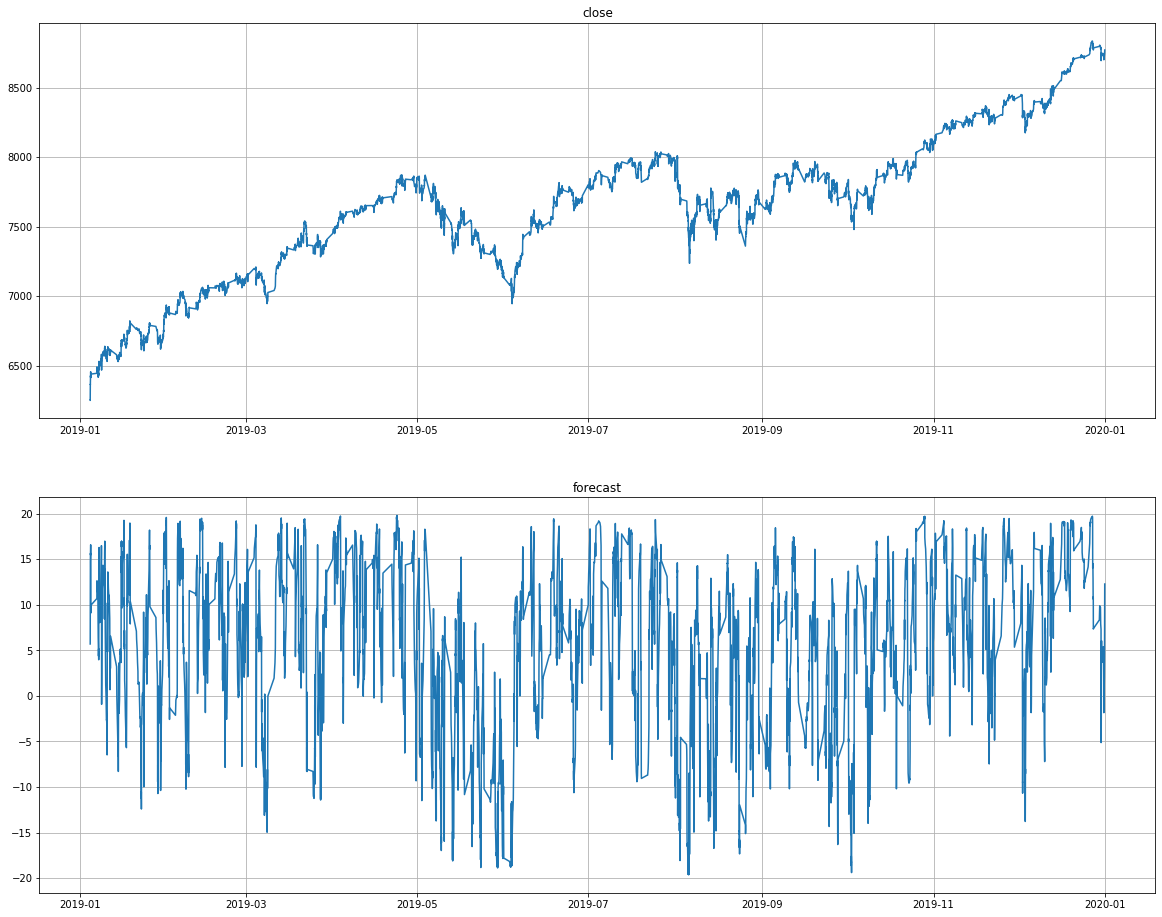

In [17]:
plot(data[['close', 'forecast']])

In [18]:
out = summary(data, slip=1.5)
out.stats

,0,3,5,6,7,10,15,17,19
Annual return,0.214103,0.168557,0.156908,0.111384,0.0282791,0.0687756,0.00111975,-0.0350547,-0.0094479
Cumulative returns,0.217848,0.171449,0.159588,0.113248,0.0287343,0.0699046,0.00113753,-0.0356011,-0.00959714
Annual volatility,0.15152,0.140815,0.126765,0.120931,0.113834,0.0912667,0.0542581,0.0435182,0.011565
Sharpe ratio,1.35637,1.17658,1.21307,0.933486,0.301552,0.774194,0.0475552,-0.798256,-0.815047
Calmar ratio,3.16851,1.87759,2.30052,1.78791,0.250494,1.51751,0.0301397,-0.719138,-0.73747
Stability,0.774195,0.486412,0.700575,0.404504,0.33222,0.467649,0.00106642,0.670667,0.0212958
Max drawdown,-0.0675721,-0.0897728,-0.0682055,-0.0622981,-0.112893,-0.0453213,-0.0371518,-0.0487454,-0.0128112
Omega ratio,1.25066,1.21659,1.22524,1.16964,1.05152,1.1521,1.01201,0.773579,0.669221
Sortino ratio,2.02361,1.80921,1.92555,1.50769,0.46736,1.29526,0.0775787,-1.11895,-1.13082
Skew,-0.136336,0.141744,0.421901,0.594194,0.480231,0.763991,1.56996,0.462179,0.76775


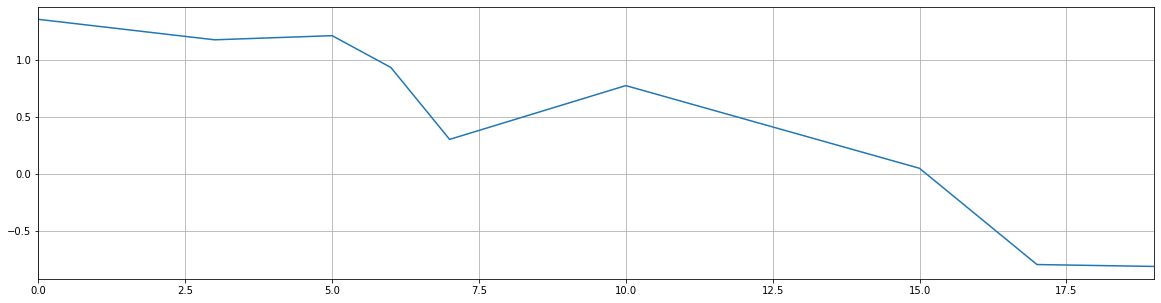

In [19]:
out.stats.loc['Sharpe ratio',].plot(figsize=(20,5), grid=True);

In [20]:
out.returns.corr()

,0,3,5,6,7,10,15,17,19
0,1.000000,0.888060,0.802031,0.789657,0.747135,0.634678,0.402098,0.231381,0.075202
3,0.888060,1.000000,0.907396,0.878701,0.841276,0.694025,0.446564,0.269048,0.084160
5,0.802031,0.907396,1.000000,0.956092,0.905702,0.732382,0.500210,0.305318,0.087046
6,0.789657,0.878701,0.956092,1.000000,0.950421,0.786664,0.513438,0.327618,0.099945
7,0.747135,0.841276,0.905702,0.950421,1.000000,0.808799,0.523001,0.311837,0.079065
10,0.634678,0.694025,0.732382,0.786664,0.808799,1.000000,0.594981,0.357392,0.121737
15,0.402098,0.446564,0.500210,0.513438,0.523001,0.594981,1.000000,0.771347,0.227228
17,0.231381,0.269048,0.305318,0.327618,0.311837,0.357392,0.771347,1.000000,0.279705
19,0.075202,0.084160,0.087046,0.099945,0.079065,0.121737,0.227228,0.279705,1.000000


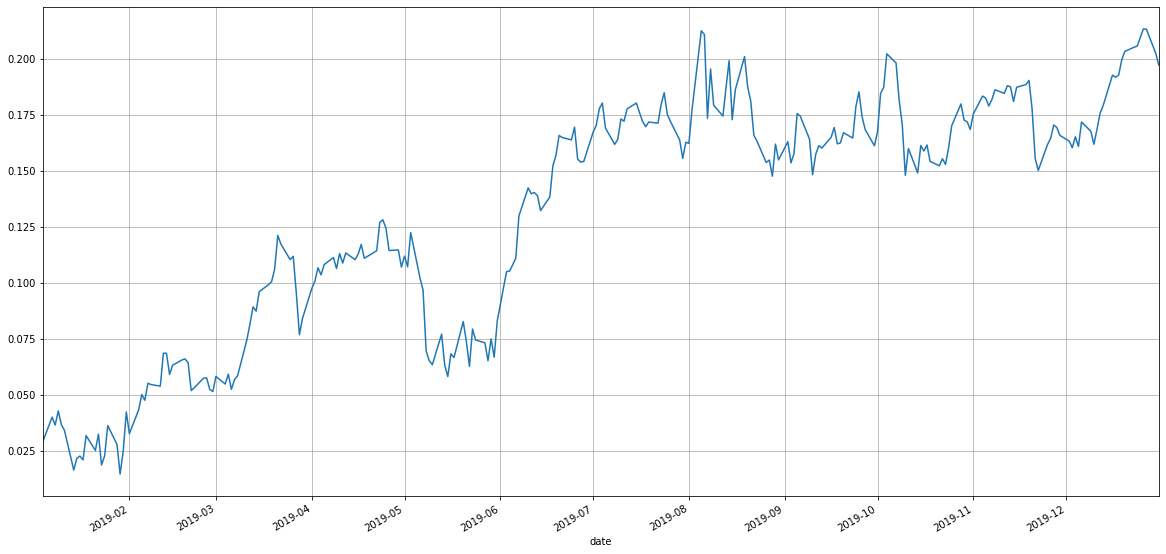

In [21]:
np.log(out.returns[0]+1).cumsum().plot(figsize=(20, 10), grid=True);

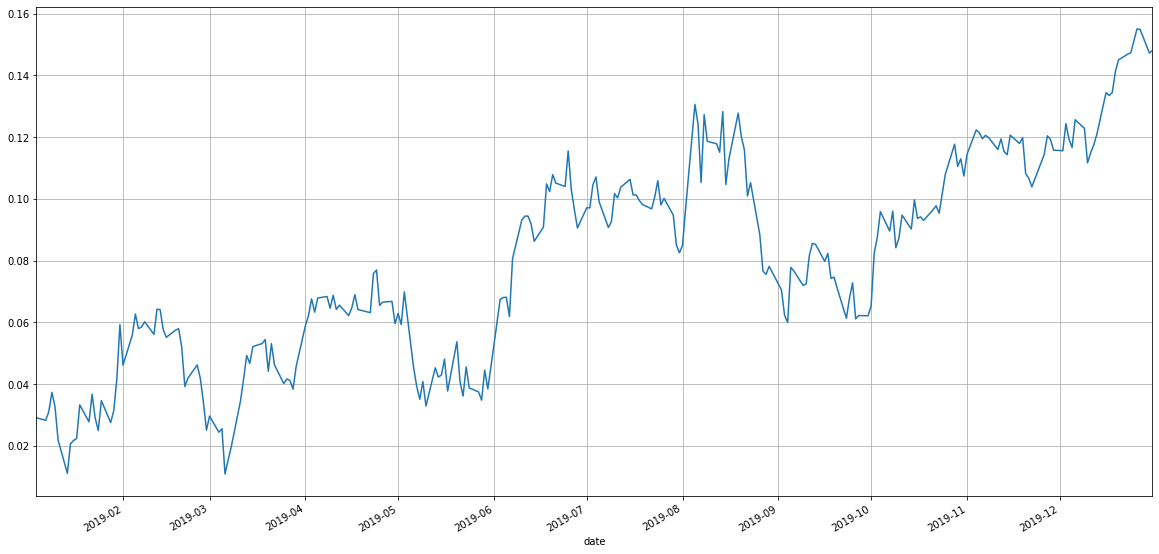

In [22]:
np.log(out.returns[5]+1).cumsum().plot(figsize=(20, 10), grid=True);

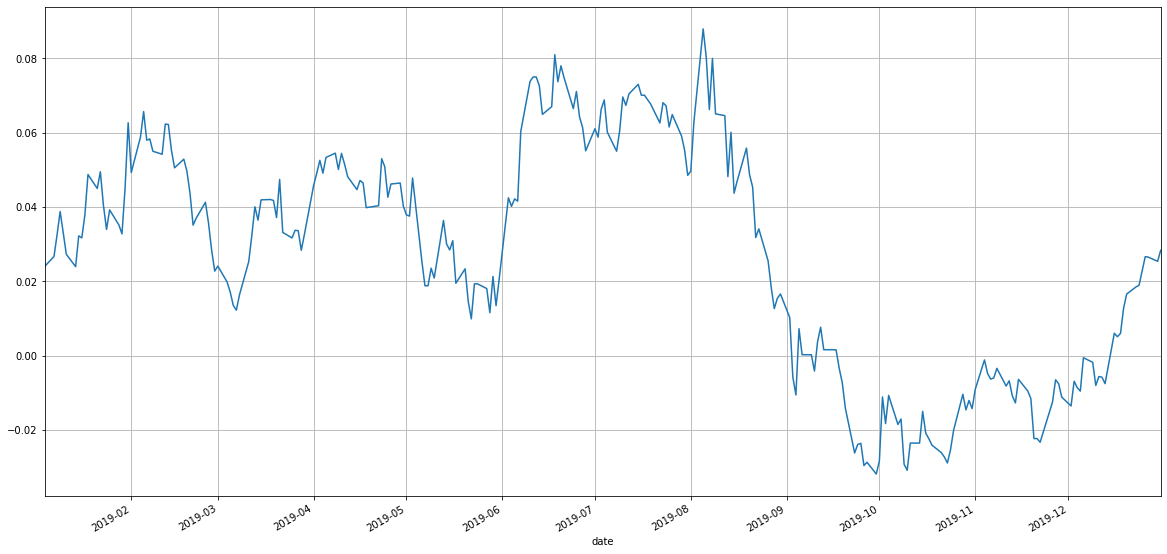

In [23]:
np.log(out.returns[7]+1).cumsum().plot(figsize=(20, 10), grid=True);

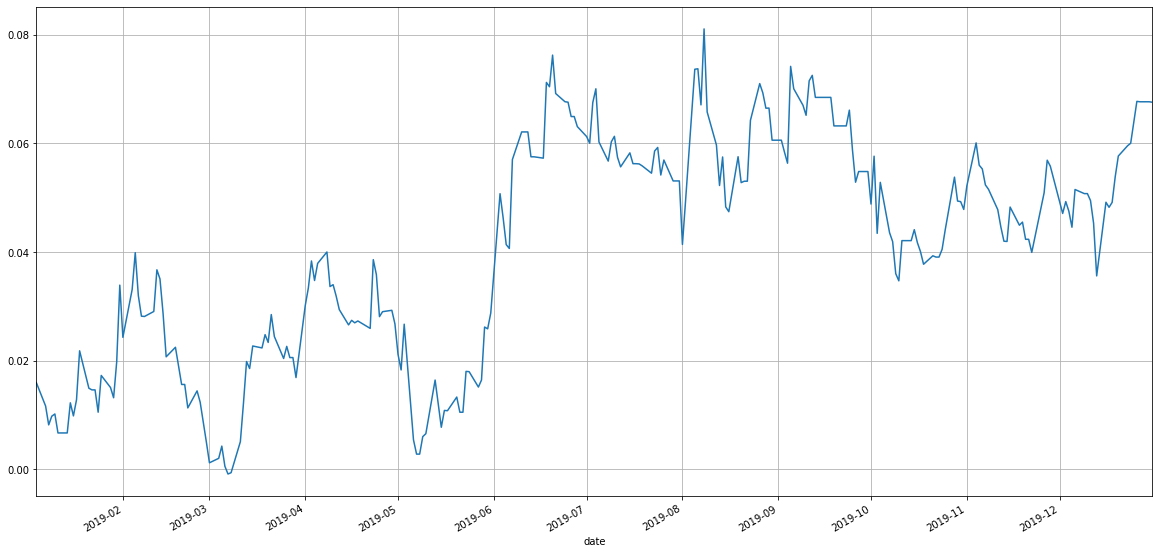

In [24]:
np.log(out.returns[10]+1).cumsum().plot(figsize=(20, 10), grid=True);

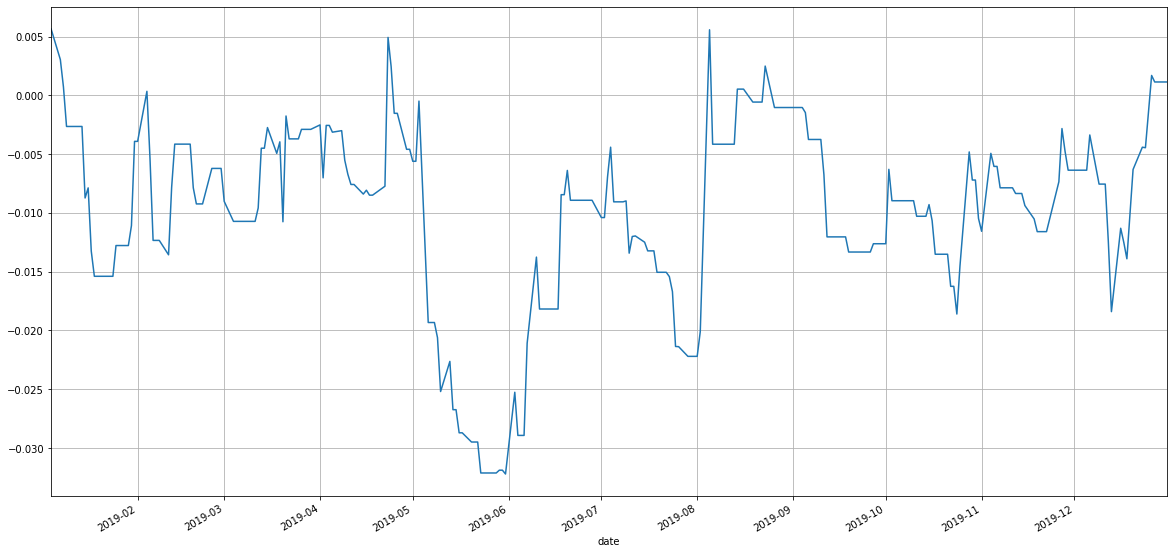

In [25]:
np.log(out.returns[15]+1).cumsum().plot(figsize=(20, 10), grid=True);